In [61]:
import numpy as np
from scipy.io import mmread
# from scipy.sparse import csr_matrix # Non usata se A è densa
import time
from scipy.optimize import minimize_scalar
import pandas as pd
import matplotlib as plt
import matplotlib.ticker as mticker



In [62]:
def projection_simplex(v, z=1.0):
    """Project vector v onto the simplex (sum(x)=z, x>=0)."""
    n = len(v)
    if n == 0: return np.array([])
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    
    
    rho_idx = -1
    for i in range(n - 1, -1, -1): 
        if u[i] + (z - cssv[i]) / (i + 1) > 0: 
            rho_idx = i
            break
    

    if rho_idx == -1: 
        if z == 0: return np.zeros(n)
        
        pass 
    theta = (cssv[rho_idx] - z) / (rho_idx + 1.0)
    
    proj_v = np.maximum(v - theta, 0)
    
   
    current_sum = np.sum(proj_v)
    if z > 1e-9: 
        if abs(current_sum - z) > 1e-7 * z: 
            if current_sum > 1e-9: 
                proj_v = proj_v * (z / current_sum)
            else: 
                  pass
    elif abs(current_sum) > 1e-7 : 
         proj_v = np.zeros(n)
         
    return proj_v


def lmo(grad):
    """Linear Minimization Oracle for the simplex."""
    i = np.argmin(grad)
    s = np.zeros_like(grad)
    s[i] = 1.0
    return s, i 

def f_l2(x, A):
    """L2-regularized objective function"""
    return x @ A @ x + 0.5 * np.dot(x, x)

def grad_l2(x, A):
    """Gradient for L2-regularized objective"""
    
    return 2 * (A @ x) + x

def f_l0(x, A, alpha=0.07, beta=5):
    """L0-regularized objective function"""
   
    reg_term = alpha * np.sum(np.exp(-beta * np.clip(x, 0, None)) - 1.0)
    return x @ A @ x + reg_term

def grad_l0(x, A, alpha=0.07, beta=5):
    """Gradient for L0-regularized objective"""
    return 2 * (A @ x) - alpha * beta * np.exp(-beta * np.clip(x, 0, None))


def line_search_generic(objective_func, x_curr, d_curr, A_matrix, gamma_max=1.0, reg_type_info='l2', alpha_l0=0.07, beta_l0=5):
    """Line search to find perfect stepsize."""
    if np.linalg.norm(d_curr) < 1e-12: 
        return 0.0
    
    def func_to_minimize(gamma_ls):
        x_candidate = x_curr + gamma_ls * d_curr 
        
        # Project candidate for L0 to ensure non-negativity for the exp term
        if reg_type_info == 'l0':
            x_candidate = np.maximum(x_candidate, 0)

        if reg_type_info == 'l2' :
            val = objective_func(x_candidate, A_matrix) 
        else: # CORRECTED BLOCK
            val = objective_func(x_candidate, A_matrix, alpha=alpha_l0, beta=beta_l0)
        return -val # We minimize the negative objective to maximize the objective
    
    if not (np.isfinite(gamma_max) and gamma_max >= 0): gamma_max = 1.0
    
    if gamma_max < 1e-12: return 0.0

    try:
        res = minimize_scalar(func_to_minimize, bounds=(0, gamma_max), method='bounded')
        gamma = res.x
        if not np.isfinite(gamma): gamma = 0.0
    except Exception:
        gamma = 0.0 
        
    return np.clip(gamma, 0.0, gamma_max)

def extract_clique(x, A, threshold=1e-5):
    """Extract clique from solution vector."""
    S = np.where(x > threshold)[0]
    if len(S) == 0:
        return []
    

    sorted_indices = S[np.argsort(-x[S])]
    clique = []
    for i in sorted_indices:
       
        is_connected = True
        for j in clique:
            if A[i, j] == 0:
                is_connected = False
                break
        if is_connected:
            clique.append(i)
    return clique


def load_graph(file_path):
    """Load graph from MTX file and return adjacency matrix."""
    sparse_matrix = mmread(file_path)
    A_dense = sparse_matrix.toarray()
    np.fill_diagonal(A_dense, 0) 
    return A_dense

# Algorithms

# Fank-Wolfe

In [63]:
def frank_wolfe(A, reg_type='l2', max_iter=400, tol=1e-6, fixed_stepsize=None):
    n = A.shape[0]
    x = np.ones(n) / n 

    objective_function = f_l2 if reg_type == 'l2' else f_l0
    gradient_function = grad_l2 if reg_type == 'l2' else grad_l0

    history = [objective_function(x, A)]

    for t in range(max_iter):
        grad_orig = gradient_function(x, A)  
        grad_min = -grad_orig                   

        s_vertex, _ = lmo(grad_min)
        d = s_vertex - x

        gap = grad_orig @ d

        if gap < tol:
            
            break


        if fixed_stepsize is not None:
            gamma = fixed_stepsize
        else:
            if reg_type == 'l2':
                gamma = line_search_generic(objective_function, x, d, A, gamma_max=1.0, reg_type_info='l2')
            else: 
                gamma = line_search_generic(objective_function, x, d, A, gamma_max=1.0, reg_type_info='l0')
       
        x = x + gamma * d

        history.append(objective_function(x, A))


    return x, history


# Pairwise Frank-Wolfe

In [64]:
def pairwise_frank_wolfe(A, reg_type='l2', max_iter=400, tol=1e-6, fixed_stepsize=None):
    n = A.shape[0]
    x0_idx = np.random.randint(n)
    x = np.zeros(n)
    x[x0_idx] = 1.0  

    objective_function = f_l2 if reg_type == 'l2' else f_l0
    gradient_function = grad_l2 if reg_type == 'l2' else grad_l0

    history = [objective_function(x, A)]

    for t in range(max_iter):
        grad_orig = gradient_function(x, A)
        grad_min = -grad_orig

        s_vertex_fw, s_index = lmo(grad_min)  

        d_for_gap = s_vertex_fw - x
        gap = grad_orig @ d_for_gap
        if gap < tol:
            break

        current_support_indices = np.where(x > 1e-9)[0]
        if len(current_support_indices) == 0:
            x.fill(0.0)
            x[s_index] = 1.0
            
            history.append(objective_function(x, A))
            continue

        v_index = current_support_indices[np.argmax(grad_orig[current_support_indices])]

        if s_index == v_index:
            d = s_vertex_fw - x 
            gamma_max_ls = 1.0
        else:
            v_vertex = np.zeros(n)
            v_vertex[v_index] = 1.0
            d = s_vertex_fw - v_vertex 
            gamma_max_ls = x[v_index]

        if fixed_stepsize is not None:
            gamma = min(fixed_stepsize, gamma_max_ls)
        else:
            gamma = line_search_generic(objective_function, x, d, A, gamma_max=gamma_max_ls, reg_type_info=reg_type)

        if s_index == v_index:
            x = (1.0 - gamma) * x + gamma * s_vertex_fw
        else:
            x[s_index] += gamma
            x[v_index] -= gamma

        x[x < 1e-10] = 0.0
        current_sum = np.sum(x)
        if abs(current_sum - 1.0) > 1e-7 and current_sum > 1e-9:
            x /= current_sum


        history.append(objective_function(x, A))


    return x, history

# Away-step Frank-Wolfe

In [65]:
def away_step_frank_wolfe(A, reg_type='l2', max_iter=400, tol=1e-6, fixed_stepsize=None):
    n = A.shape[0]

    x0_idx = np.random.randint(n)
    x = np.zeros(n)
    x[x0_idx] = 1.0

    objective_function = f_l2 if reg_type == 'l2' else f_l0
    gradient_function = grad_l2 if reg_type == 'l2' else grad_l0

    history = [objective_function(x, A)]

    for t in range(max_iter):
        grad_orig = gradient_function(x, A)
        grad_min = -grad_orig

        s_vertex_fw, s_index = lmo(grad_min)
        d_fw = s_vertex_fw - x
        
        gap_fw = grad_orig @ d_fw
        if gap_fw < tol:
            break

        current_support_indices = np.where(x > 1e-9)[0]
        if len(current_support_indices) == 0:
            x.fill(0.0)
            x[s_index] = 1.0
            history.append(objective_function(x, A))
            continue
            
        v_index = current_support_indices[np.argmax(grad_orig[current_support_indices])]
        v_vertex = np.zeros(n)
        v_vertex[v_index] = 1.0
        d_away = x - v_vertex
        
        potential_progress_fw = grad_orig @ d_fw
        potential_progress_away = grad_orig @ d_away
        
        direction_type = ""
        if potential_progress_fw >= potential_progress_away:
            d = d_fw
            gamma_max_ls = 1.0
            direction_type = "FW"
        else:
            d = d_away
            alpha_v_t = x[v_index]
            if abs(1.0 - alpha_v_t) < 1e-9 or np.linalg.norm(d_away) < 1e-9:
                d = d_fw
                gamma_max_ls = 1.0
                direction_type = "FW (fallback from Away)"
            else:
                gamma_max_ls = alpha_v_t / (1.0 - alpha_v_t)
                direction_type = "Away"
        
        if fixed_stepsize is not None:
            gamma = min(fixed_stepsize, gamma_max_ls)
        else:
            gamma = line_search_generic(objective_function, x, d, A, gamma_max=gamma_max_ls, reg_type_info=reg_type)

        if direction_type.startswith("FW"):
            x = (1.0 - gamma) * x
            x[s_index] += gamma
        elif direction_type == "Away":
            x = (1.0 + gamma) * x
            x[v_index] -= gamma
        
        x[x < 1e-10] = 0.0
        current_sum = np.sum(x)
        if abs(current_sum - 1.0) > 1e-7 and current_sum > 1e-9:
            x /= current_sum
        

        history.append(objective_function(x, A))
            
    return x, history

# Projected Gradient

In [66]:
def projected_gradient(A, reg_type='l2', max_iter=200, tol=1e-6, lr_initial=0.1, fixed_learning_rate=None):
    n = A.shape[0]
    x = np.ones(n) / n  

    if reg_type == 'l2':
        objective_function = f_l2
        gradient_function = grad_l2
    else:  
        objective_function = f_l0
        gradient_function = grad_l0

    history = [objective_function(x, A)]

    for t in range(max_iter):
       
        grad_orig = gradient_function(x, A)

        
        if fixed_learning_rate is not None:
            gamma = fixed_learning_rate
        else:
            gamma = line_search_generic(
                objective_func=objective_function,
                x_curr=x,
                d_curr=grad_orig, 
                A_matrix=A,
                gamma_max=lr_initial,
                reg_type_info=reg_type
            )

        x_candidate_unprojected = x + gamma * grad_orig

        x_next = projection_simplex(x_candidate_unprojected)

        if np.linalg.norm(x_next - x) < tol:
            break

        x = x_next


        history.append(objective_function(x, A))

    return x, history


# Experiments execution

In [67]:

graph_files = ["./data/C250-9.mtx", "./data/C500-9.mtx", "./data/C2000-9.mtx"]
reg_types = ['l2', 'l0']
algorithms = {
    'FW': frank_wolfe,
    'PFW': pairwise_frank_wolfe,
    'AFW': away_step_frank_wolfe,
    'PGD': projected_gradient
}
stepsize_options = [None, 0.15]


results_list = []
for graph_file in graph_files:
    print(f"\n--- Processing graph file: {graph_file} ---")
    try:
        A = load_graph(graph_file)
    except FileNotFoundError:
        print(f"Errore: File del grafo '{graph_file}' non trovato. Salto questo file.")
        continue
    n = A.shape[0]

    
    for step in stepsize_options:
        step_label = 'Linear Search' if step is None else f'Fixed ({step})'
        print(f"--- Running experiments with stepsize: {step_label} for {graph_file} ---")
        for reg_type in reg_types:
            for algo_name, algo_func in algorithms.items():
                print(f"Running: {algo_name} - Reg: {reg_type} - Step: {step_label}")
                try:
                    start_time = time.perf_counter()

                    kwargs = {'A': A, 'reg_type': reg_type, 'max_iter': 1000}
                    if algo_name == 'PGD':
                        kwargs['fixed_learning_rate'] = step 
                        if step is None:
                            kwargs['lr_initial'] = 0.1
                    else:
                        kwargs['fixed_stepsize'] = step

                    x, history = algo_func(**kwargs)

                    runtime = time.perf_counter() - start_time
                    clique = extract_clique(x, A)
                    clique_size = len(clique)

                    is_valid = True
                    if clique_size > 1:
                        is_valid = all(A[i, j] == 1 for i in clique for j in clique if i != j)

                    results_list.append({
                        'Graph File': graph_file,
                        'Algorithm': algo_name,
                        'Regularization': reg_type,
                        'Stepsize': step_label,
                        'Clique Size': clique_size,
                        'Valid Clique': is_valid,
                        'Runtime (s)': runtime,
                        'History': history
                    })
                except Exception as e:
                    print(f"Error in {algo_name} with {reg_type} and step {step_label} for {graph_file}: {e}")
                    import traceback
                    traceback.print_exc()
                    results_list.append({
                        'Graph File': graph_file,
                        'Algorithm': algo_name, 'Regularization': reg_type,
                        'Stepsize': step_label, 'Clique Size': -1,
                        'Valid Clique': False, 'Runtime (s)': -1,
                        'Error': str(e), 'History': []
                    })


print("\n" + "="*80)
print("                 FINAL RESULTS TABLE (Pandas DataFrame)                  ")
print("="*80)

if results_list:
    df_results = pd.DataFrame(results_list)


    columns_to_show = [col for col in df_results.columns if col != 'History']


    display_order = ['Graph File', 'Algorithm', 'Regularization', 'Stepsize', 'Clique Size', 'Valid Clique', 'Runtime (s)']
    if 'Error' in columns_to_show:
        display_order.append('Error')

    final_columns = [col for col in display_order if col in columns_to_show]

    final_columns.extend([col for col in columns_to_show if col not in final_columns])


    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(df_results[final_columns].to_string())

print("="*80)



--- Processing graph file: ./data/C250-9.mtx ---
--- Running experiments with stepsize: Linear Search for ./data/C250-9.mtx ---
Running: FW - Reg: l2 - Step: Linear Search
Running: PFW - Reg: l2 - Step: Linear Search
Running: AFW - Reg: l2 - Step: Linear Search
Running: PGD - Reg: l2 - Step: Linear Search
Running: FW - Reg: l0 - Step: Linear Search
Running: PFW - Reg: l0 - Step: Linear Search
Running: AFW - Reg: l0 - Step: Linear Search
Running: PGD - Reg: l0 - Step: Linear Search
--- Running experiments with stepsize: Fixed (0.15) for ./data/C250-9.mtx ---
Running: FW - Reg: l2 - Step: Fixed (0.15)
Running: PFW - Reg: l2 - Step: Fixed (0.15)
Running: AFW - Reg: l2 - Step: Fixed (0.15)
Running: PGD - Reg: l2 - Step: Fixed (0.15)
Running: FW - Reg: l0 - Step: Fixed (0.15)
Running: PFW - Reg: l0 - Step: Fixed (0.15)
Running: AFW - Reg: l0 - Step: Fixed (0.15)
Running: PGD - Reg: l0 - Step: Fixed (0.15)

--- Processing graph file: ./data/C500-9.mtx ---
--- Running experiments with stepsi

In [ ]:
# df_results.to_csv("results.csv")

# Graphs

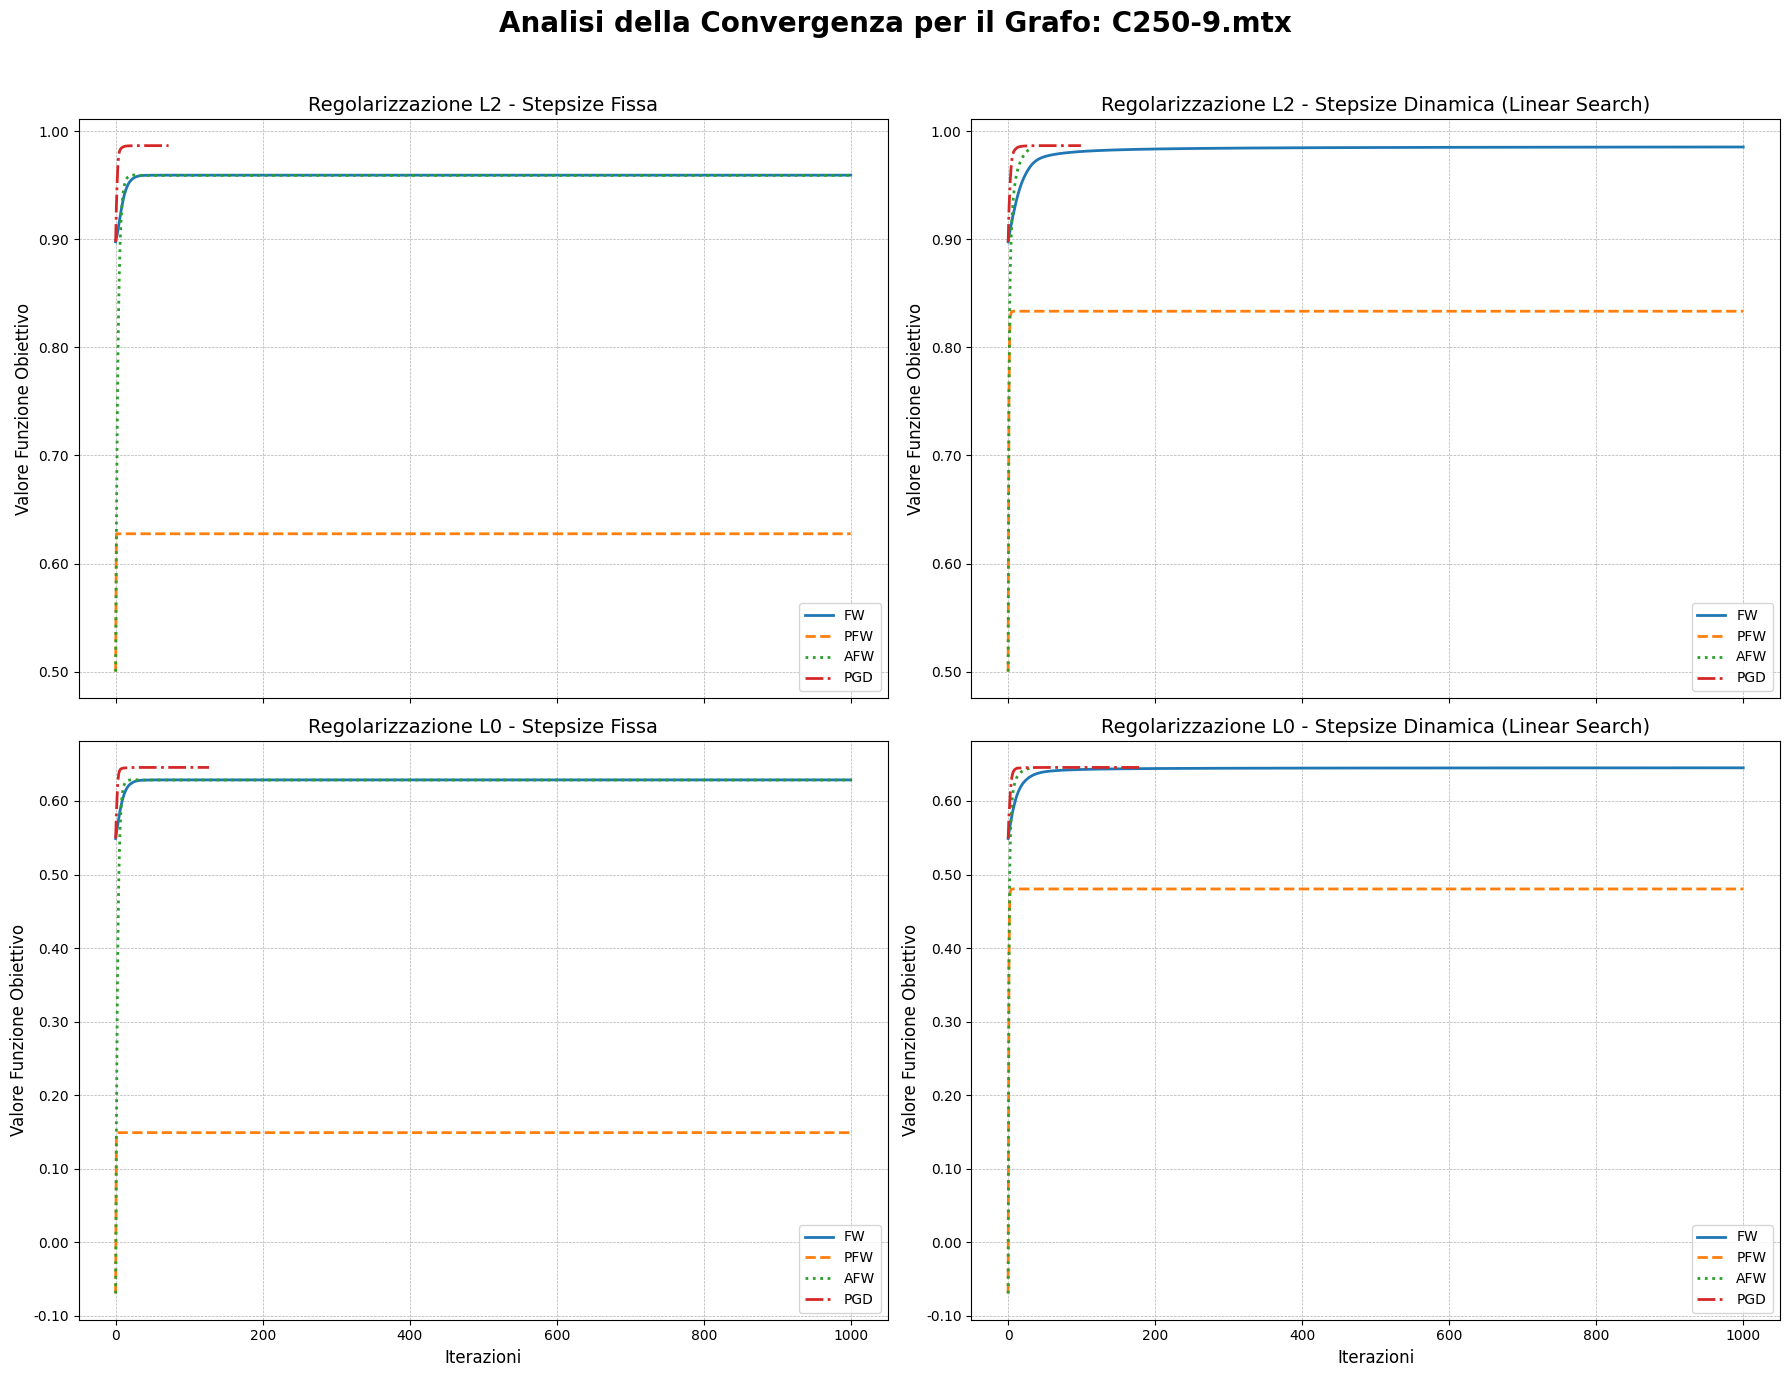

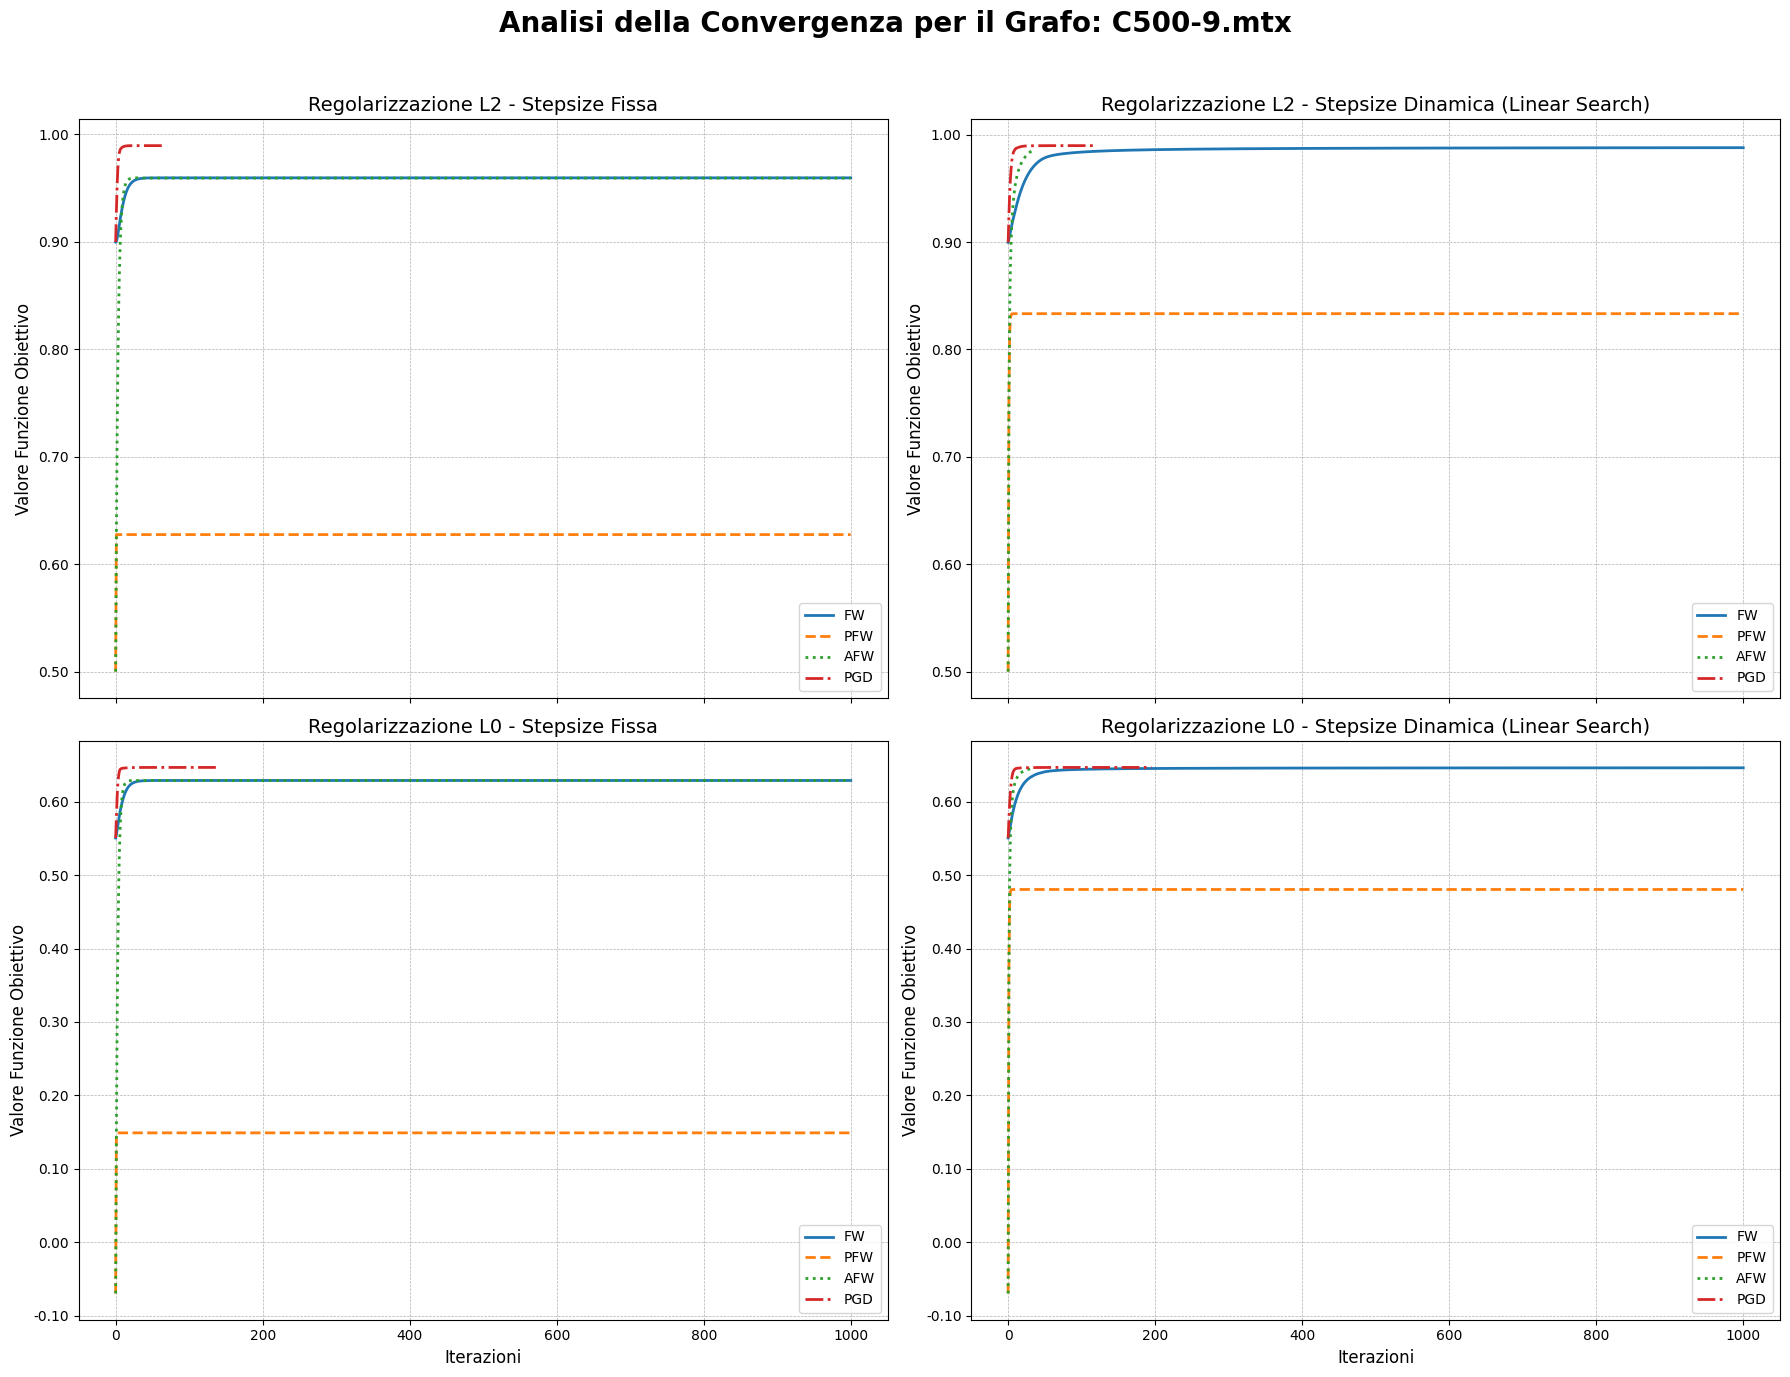

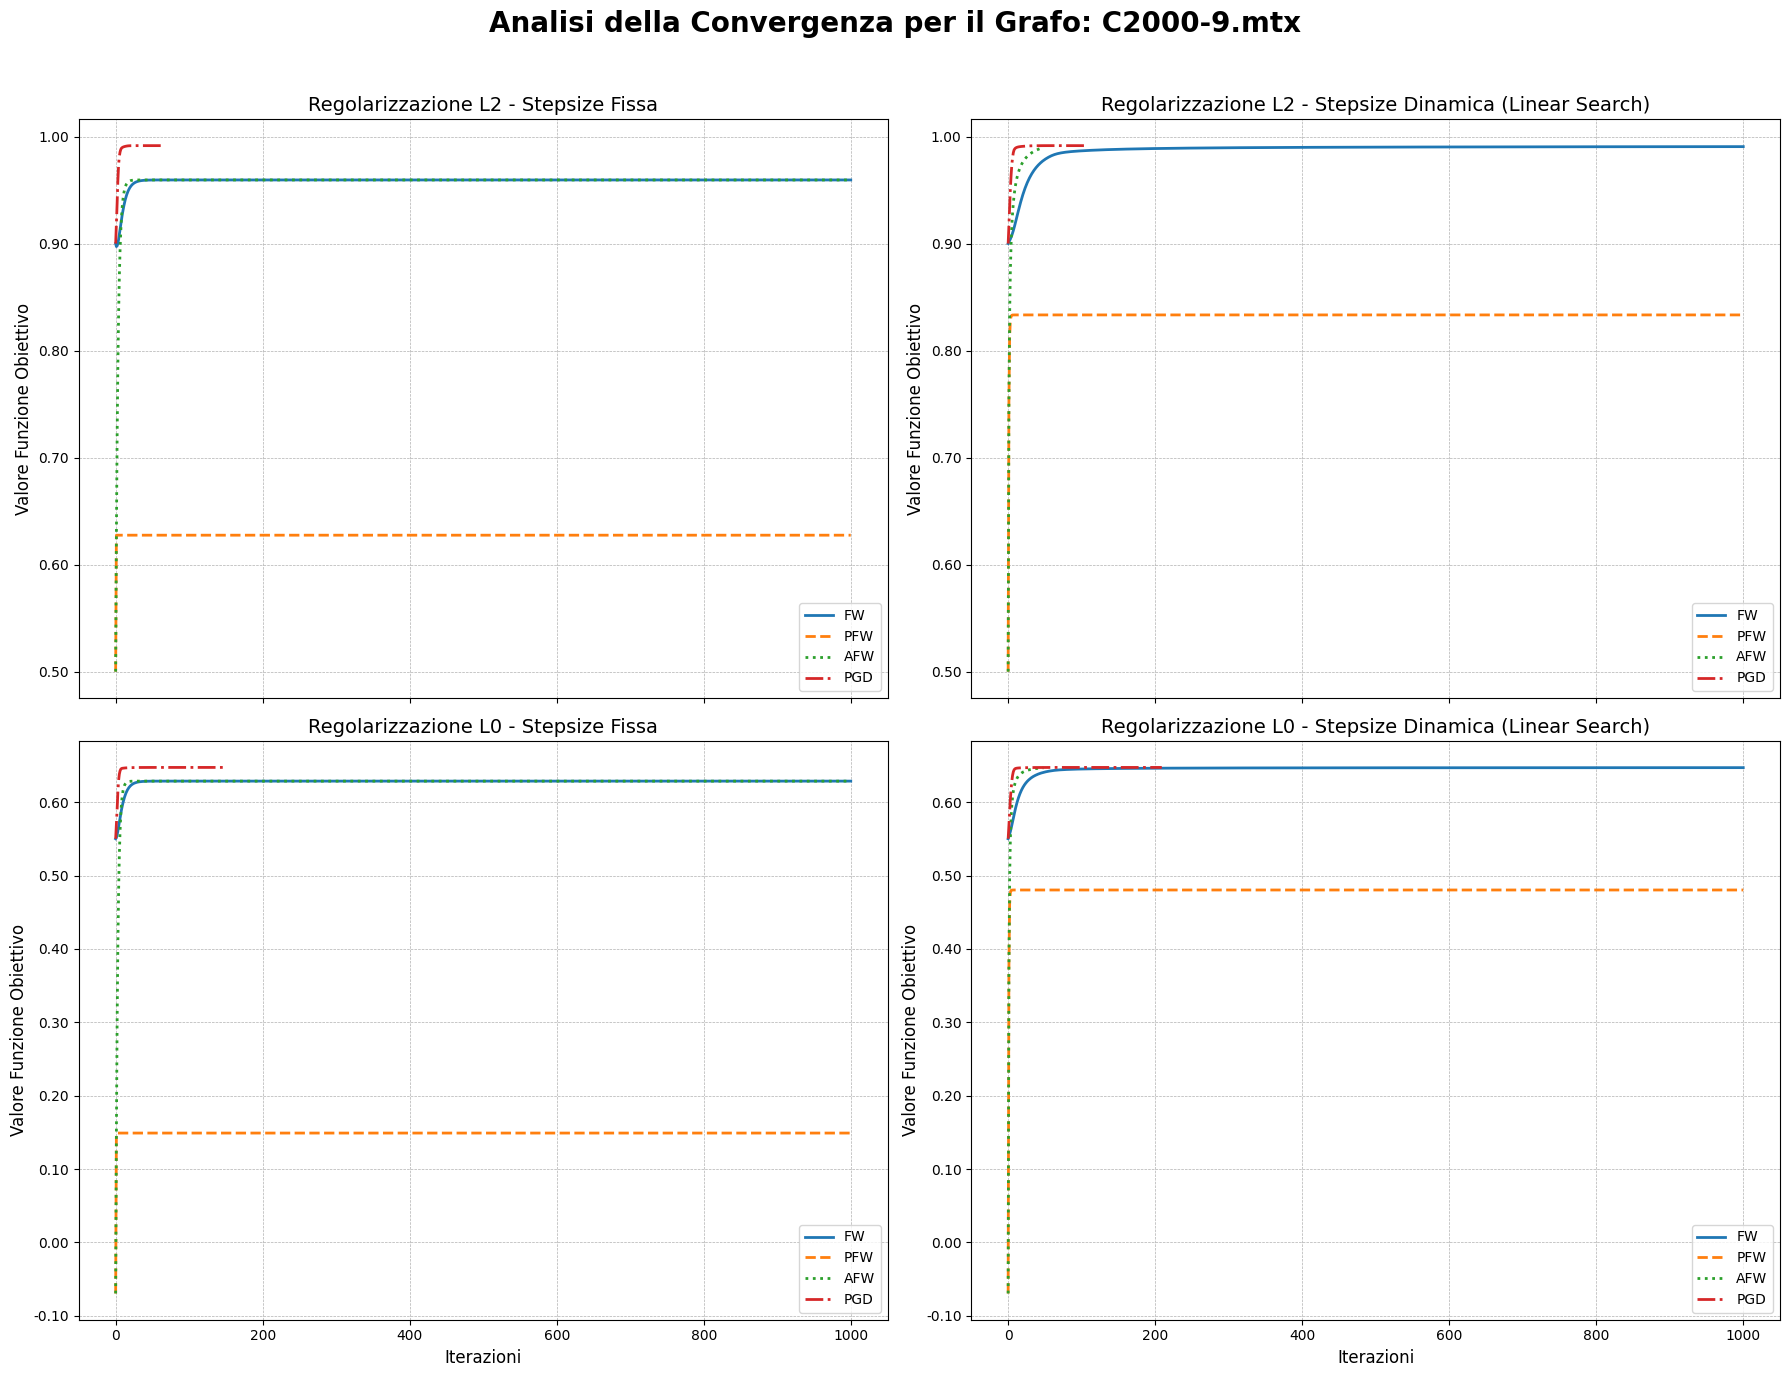

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Definisce colori e stili per una migliore leggibilità
palette = {
    'FW': ('#1f77b4', '-'),   # Blu
    'PFW': ('#ff7f0e', '--'), # Arancione
    'AFW': ('#2ca02c', ':'),   # Verde
    'PGD': ('#d62728', '-.')  # Rosso
}

# Ottiene la lista unica di file di grafo dal DataFrame
unique_graphs = df_results['Graph File'].unique()

# Itera su ogni file di grafo per creare una figura separata
for graph in unique_graphs:
    fig, axes = plt.subplots(2, 2, figsize=(18, 14), sharex=True)
    fig.suptitle(f"Analisi della Convergenza per il Grafo: {graph.split('/')[-1]}", fontsize=20, fontweight='bold')

    # Filtra il DataFrame per il grafo corrente
    df_graph = df_results[df_results['Graph File'] == graph]

    # Mappa per titoli e filtri
    plot_map = {
        (0, 0): ('Regolarizzazione L2 - Stepsize Fissa', (df_graph['Regularization'] == 'l2') & (df_graph['Stepsize'].str.contains('Fixed'))),
        (0, 1): ('Regolarizzazione L2 - Stepsize Dinamica (Linear Search)', (df_graph['Regularization'] == 'l2') & (df_graph['Stepsize'] == 'Linear Search')),
        (1, 0): ('Regolarizzazione L0 - Stepsize Fissa', (df_graph['Regularization'] == 'l0') & (df_graph['Stepsize'].str.contains('Fixed'))),
        (1, 1): ('Regolarizzazione L0 - Stepsize Dinamica (Linear Search)', (df_graph['Regularization'] == 'l0') & (df_graph['Stepsize'] == 'Linear Search'))
    }

    # Itera sulla mappa per creare ogni subplot
    for (row, col), (title, condition) in plot_map.items():
        ax = axes[row, col]
        df_subset = df_graph[condition]

        if df_subset.empty:
            ax.text(0.5, 0.5, 'Nessun dato disponibile', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        else:
            # Plotta la history per ogni algoritmo
            for _, result_row in df_subset.iterrows():
                algo = result_row['Algorithm']
                history = result_row['History']
                if history: # Controlla se la history non è vuota
                    color, style = palette.get(algo, ('black', '-'))
                    ax.plot(history, label=algo, color=color, linestyle=style, linewidth=2)

        # Impostazioni del subplot
        ax.set_title(title, fontsize=14, fontweight='medium')
        ax.set_ylabel("Valore Funzione Obiettivo", fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend()
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))


    # Impostazioni comuni per le righe di subplot
    for i in range(2):
        axes[i, 0].set_ylabel("Valore Funzione Obiettivo", fontsize=12)
    for i in range(2):
        axes[1, i].set_xlabel("Iterazioni", fontsize=12)


    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # Salva la figura invece di mostrarla, per un migliore output
    # plt.savefig(f"plot_{graph.split('/')[-1].replace('.mtx', '')}.png")
    plt.show()

Number of valid results for plotting: 48


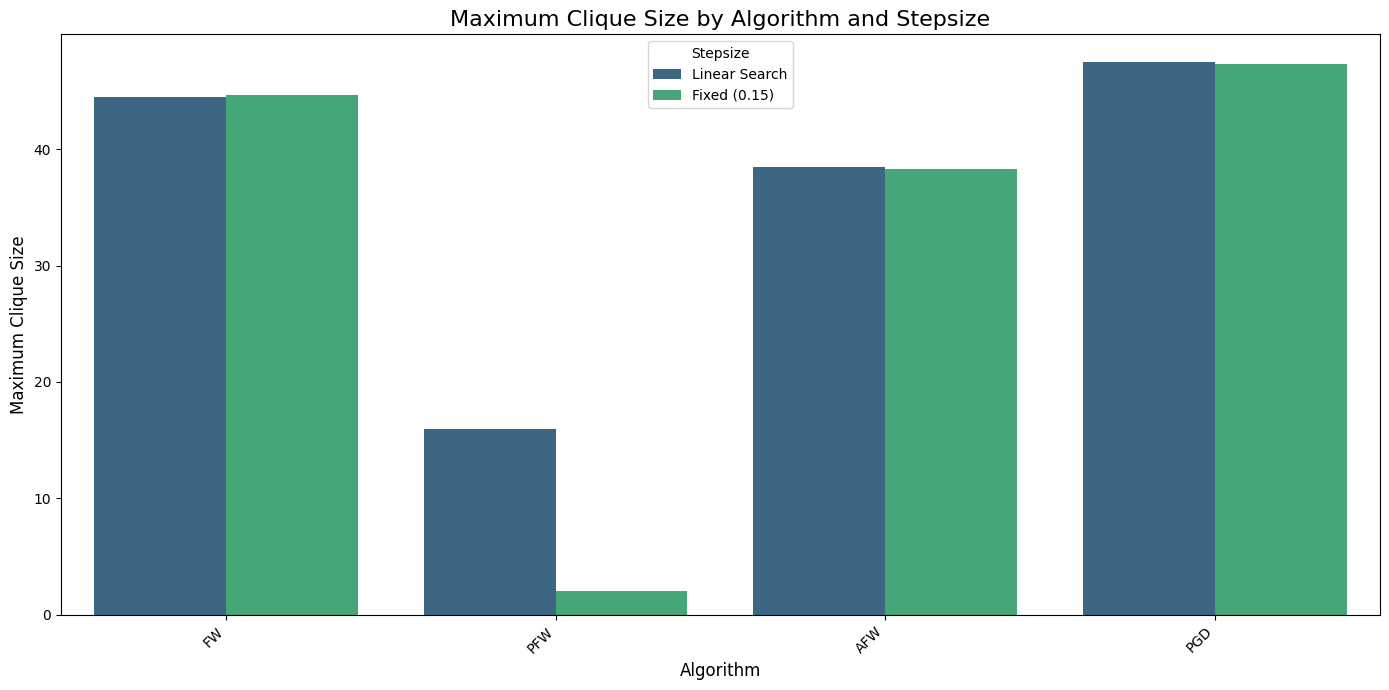

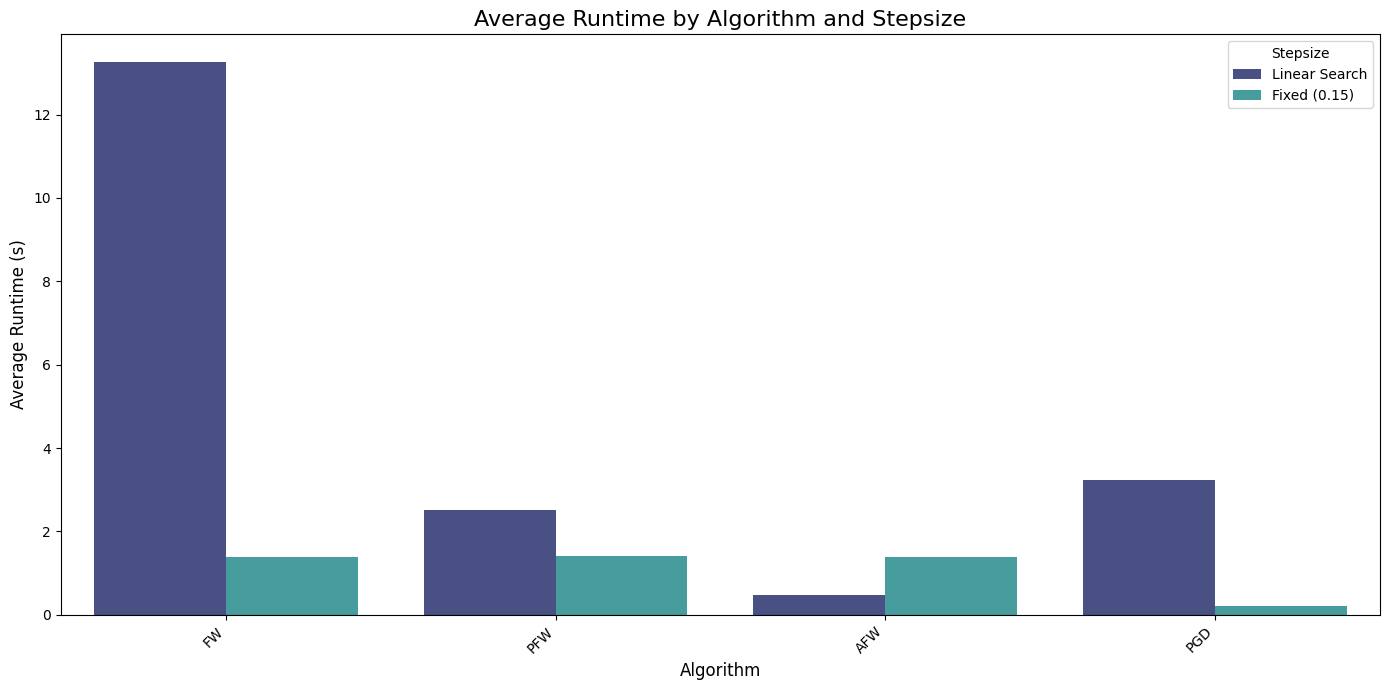

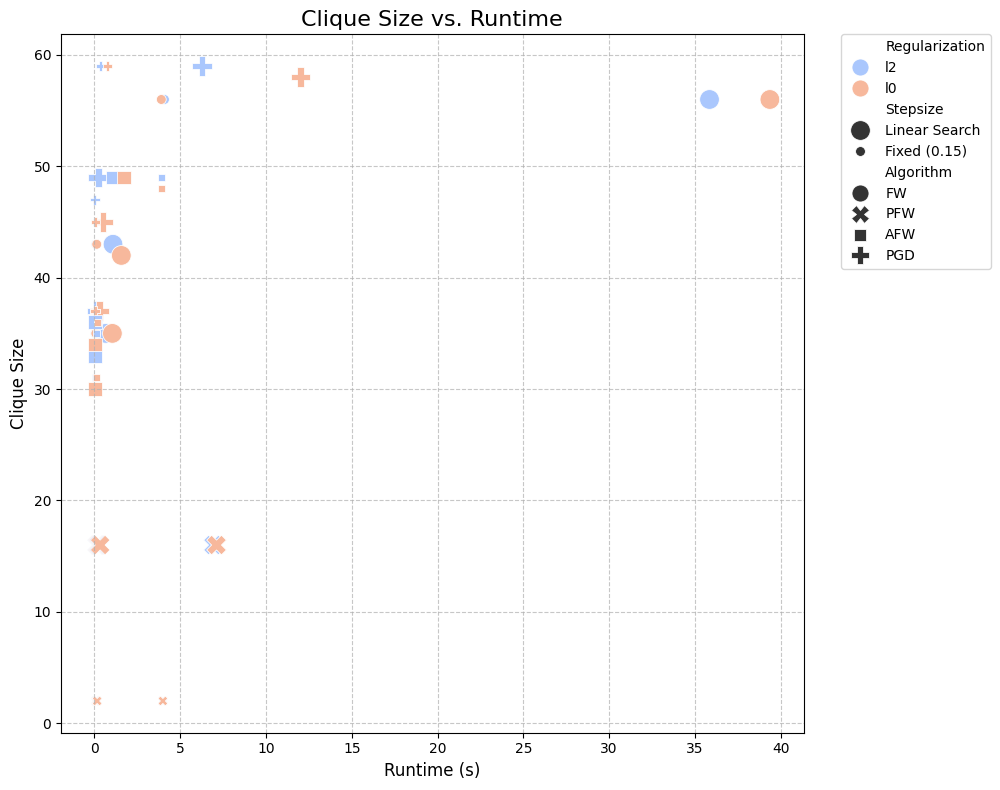

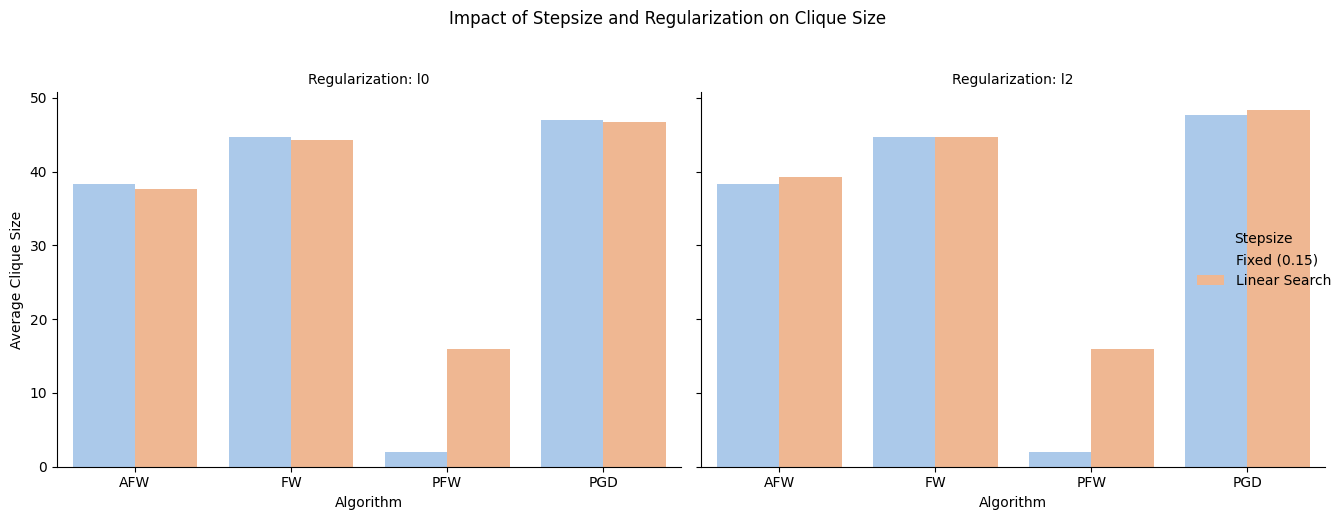

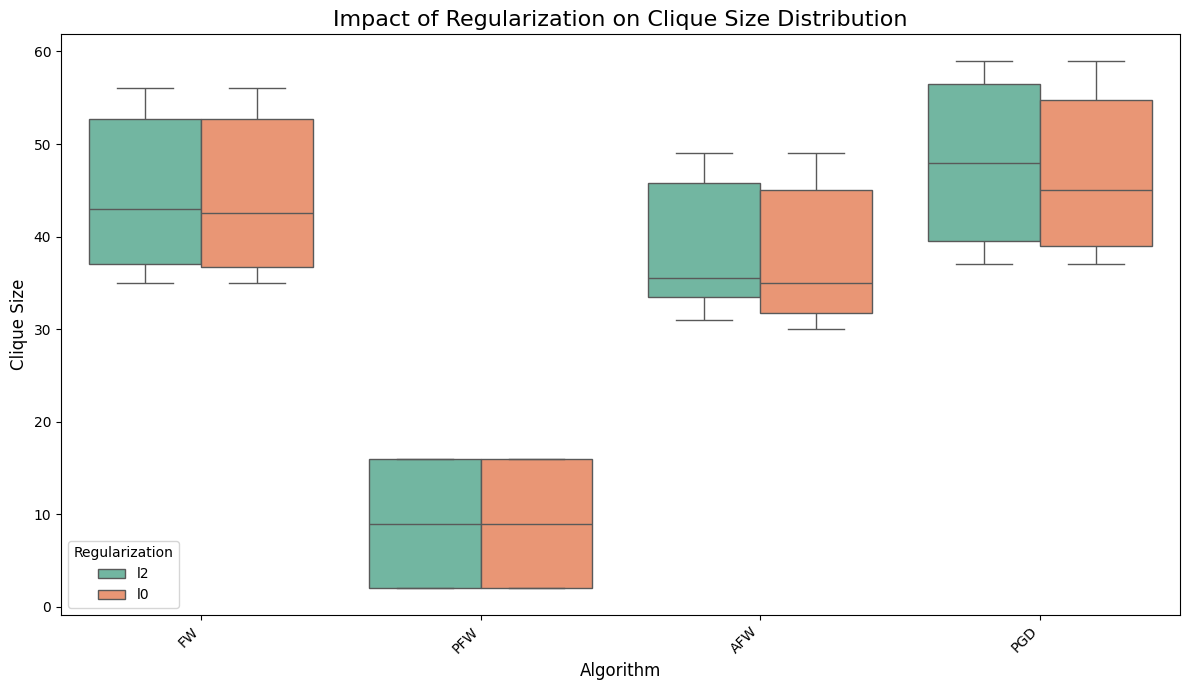

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

df_valid_results = df_results[(df_results['Valid Clique'] == True) & (df_results['Clique Size'] > 0)]

if 'Error' in df_valid_results.columns:
    df_valid_results = df_valid_results[df_valid_results['Error'].isnull()]

if df_valid_results.empty:
    print("Warning: No valid results found after filtering. Plots might be empty or not generated.")
else:
    print(f"Number of valid results for plotting: {len(df_valid_results)}")
    
    plt.figure(figsize=(14, 7))
    sns.barplot(data=df_valid_results, x='Algorithm', y='Clique Size', hue='Stepsize', palette='viridis', errorbar=None)
    plt.title('Maximum Clique Size by Algorithm and Stepsize', fontsize=16)
    plt.xlabel('Algorithm', fontsize=12)
    plt.ylabel('Maximum Clique Size', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Stepsize')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))
    sns.barplot(data=df_valid_results, x='Algorithm', y='Runtime (s)', hue='Stepsize', palette='mako', errorbar=None)
    plt.title('Average Runtime by Algorithm and Stepsize', fontsize=16)
    plt.xlabel('Algorithm', fontsize=12)
    plt.ylabel('Average Runtime (s)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Stepsize')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df_valid_results, x='Runtime (s)', y='Clique Size',
                    hue='Regularization', style='Algorithm', size='Stepsize', 
                    sizes=(50, 200), palette='coolwarm', s=150)
    plt.title('Clique Size vs. Runtime', fontsize=16)
    plt.xlabel('Runtime (s)', fontsize=12)
    plt.ylabel('Clique Size', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

    grouped_clique = df_valid_results.groupby(['Algorithm', 'Regularization', 'Stepsize'])['Clique Size'].mean().reset_index()
    
    if not grouped_clique.empty:
        g = sns.catplot(data=grouped_clique, x='Algorithm', y='Clique Size', hue='Stepsize',
                        col='Regularization', kind='bar', palette='pastel', height=5, aspect=1.2)
        g.fig.suptitle('Impact of Stepsize and Regularization on Clique Size', y=1.03)
        g.set_axis_labels("Algorithm", "Average Clique Size")
        g.set_titles("Regularization: {col_name}")
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data for the 'Impact of Stepsize on Clique Size' plot.")

    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df_valid_results, x='Algorithm', y='Clique Size', hue='Regularization', palette='Set2')
    plt.title('Impact of Regularization on Clique Size Distribution', fontsize=16)
    plt.xlabel('Algorithm', fontsize=12)
    plt.ylabel('Clique Size', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Regularization')
    plt.tight_layout()
    plt.show()